In [2]:
# Analisi dataset
import os
from functools import reduce

import rapids_singlecell as rsc
os.listdir("dataset/h5ad")
import scanpy as sc

In [23]:


gse138266 = sc.read_h5ad("dataset/h5ad/gse138266_pbmc.h5ad")
gse144744 = sc.read_h5ad("dataset/h5ad/gse144744_pbmc.h5ad")
gse194078 = sc.read_h5ad("dataset/h5ad/gse194078_pbmc.h5ad")
gse227954 = sc.read_h5ad("dataset/h5ad/gse227954_pbmc.h5ad")

In [24]:
def analisi_dataset(dataset_anndata):
    # Print dell'annadata
    print(dataset_anndata)
    # partiamo con la stampa delle cellule predette
    print(dataset_anndata.obs['predicted.celltype.l1'].value_counts())

In [25]:
analisi_dataset(gse138266)
analisi_dataset(gse144744)
analisi_dataset(gse194078)
analisi_dataset(gse227954)

# Siccome in GSE227954 Condition era solo MS, la colonna è rimossa, la riaggiungo.
gse227954.obs["Condition"] = "MS"
gse144744.obs["Patient"] = gse144744.obs["donor"]
gse138266.obs["Condition"] = gse138266.obs["Patient.Class"]


# label per i dataset
gse227954.obs['dataset'] = "gse227954"
gse144744.obs['dataset'] = "gse144744"
gse138266.obs['dataset'] = "gse138266"
gse194078.obs['dataset'] = "gse194078"


AnnData object with n_obs × n_vars = 40207 × 33694
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Patient.Class', 'percent.mt', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score'
    var: 'name'
predicted.celltype.l1
CD4 T      15747
CD8 T       6583
Mono        6461
NK          3729
B           3476
other       2682
other T     1050
DC           479
Name: count, dtype: int64
AnnData object with n_obs × n_vars = 491888 × 15354
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment', 'percent.mt', 'predicted.celltype.l1.score', '

In [26]:
# andiamo a mettere tutto in una lista 
anndatas = [gse138266, gse144744, gse194078, gse227954]
#prendiamo i geni comuni a tutti
common_genes = reduce(lambda x, y: x.intersection(y), [adata.var_names for adata in anndatas])
print(f"Common genes: {len(common_genes)}")
# Manteniamo solo i comuni
anndatas = [adata[:, common_genes] for adata in anndatas]

# vogliamo fare lo stesso per le colonne comuni
common_obs_columns = reduce(lambda x, y: x.intersection(y), [adata.obs.columns for adata in anndatas])
print(f"Obs comuni: {common_obs_columns}")
for adata in anndatas:
    adata.obs = adata.obs[common_obs_columns]  # Subset .obs columns


Common genes: 14363
Obs comuni: Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'percent.mt',
       'predicted.celltype.l1.score', 'predicted.celltype.l1',
       'predicted.celltype.l2.score', 'predicted.celltype.l2',
       'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score',
       'Condition', 'dataset'],
      dtype='object')


In [27]:
anndatas

[AnnData object with n_obs × n_vars = 40207 × 14363
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'percent.mt', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'Condition', 'dataset'
     var: 'name',
 AnnData object with n_obs × n_vars = 491888 × 14363
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'percent.mt', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'Condition', 'dataset'
     var: 'name',
 AnnData object with n_obs × n_vars = 39883 × 14363
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'percent.mt', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.

In [28]:
# andiamo a metterli tutti insieme
import anndata
concat_anndata = anndata.concat(anndatas, join='outer', merge="same")

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [29]:
print(concat_anndata)

import numpy as np

# Convert sparse matrix to dense matrix
dense_matrix = concat_anndata.X.toarray()

# Check for NaN values
has_nan = np.isnan(dense_matrix).any()

print("Contains NaN values:", has_nan)
del concat_anndata.obsm["X_pca"]
del concat_anndata.obsm["X_umap"]
# Rimuovi il grafo dei vicini
if "neighbors" in gse227954.uns:
    del concat_anndata.uns["neighbors"]

if "distances" in gse227954.obsp:
    del concat_anndata.obsp["distances"]

if "connectivities" in gse227954.obsp:
    del concat_anndata.obsp["connectivities"]

import numpy as np
import scipy.sparse as sp

# Ensure sparse matrix is in CSR format (efficient row-wise operations)
if sp.issparse(concat_anndata.X):
    concat_anndata = concat_anndata[:, np.array(concat_anndata.X.sum(axis=0)).flatten() > 0]
else:
    concat_anndata = concat_anndata[:, np.any(concat_anndata.X > 0, axis=0)]
    
print(concat_anndata)


AnnData object with n_obs × n_vars = 589218 × 14363
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'percent.mt', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'Condition', 'dataset'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
Contains NaN values: False
View of AnnData object with n_obs × n_vars = 589218 × 14362
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'percent.mt', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'Condition', 'dataset'
    var: 'name'


In [30]:
print("Running PCA...")
rsc.pp.pca(concat_anndata)
# facciamo un semplice umap, sostituendo la libreria con rsc
print("Finding neighbors...")
rsc.pp.neighbors(concat_anndata)
print("Running UMAP on GPU")
rsc.tl.umap(concat_anndata)

Running PCA...


/usr/local/lib/python3.10/dist-packages/rapids_singlecell/preprocessing/_pca.py:222: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Finding neighbors...
Running UMAP on GPU


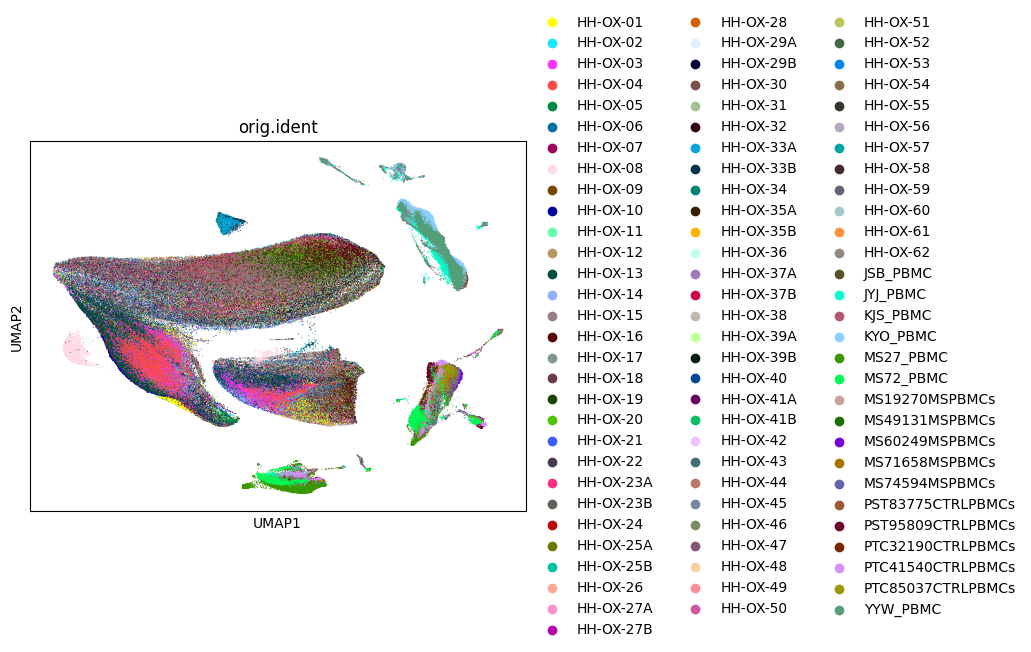

In [ ]:
sc.pl.umap(
    concat_anndata,
    color=["orig.ident"],
    # Setting a smaller point size to get prevent overlap
    size=2,
    wspace=0.4
)

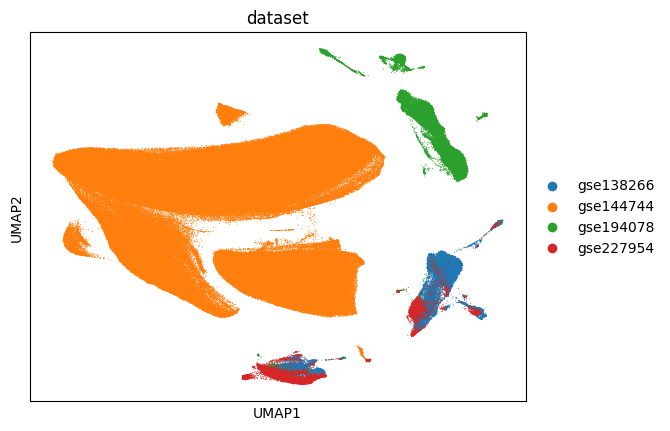

In [32]:
sc.pl.umap(
    concat_anndata,
    color=["dataset"],
    # Setting a smaller point size to get prevent overlap
    size=2,
    wspace=0.4
)

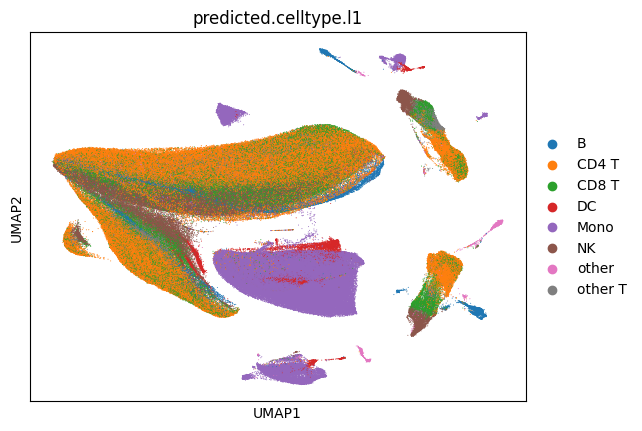

In [33]:
sc.pl.umap(
    concat_anndata,
    color=["predicted.celltype.l1"],
    # Setting a smaller point size to get prevent overlap
    size=2,
    wspace=0.4
)

In [34]:
concat_anndata.obs['predicted.celltype.l1'].value_counts()

predicted.celltype.l1
CD4 T      239553
Mono       124928
CD8 T      107182
NK          61761
other T     25166
B           16957
DC           7877
other        5794
Name: count, dtype: int64

In [14]:
concat_anndata.write("pre_integrazione_pbmc_merge.h5ad", compression='gzip')

# Passiamo all'integrazione

In [35]:
import scgen
import scanpy as sc
#concat_anndata = sc.read_h5ad("dataset/pre_integrazione_pbmc_merge.h5ad")

In [36]:
scgen.SCGEN.setup_anndata(concat_anndata, batch_key="orig.ident", labels_key="predicted.celltype.l2")

In [37]:
concat_anndata
concat_anndata.obs_names_make_unique()
print(concat_anndata)

AnnData object with n_obs × n_vars = 589218 × 14362
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'percent.mt', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'Condition', 'dataset', '_scvi_batch', '_scvi_labels'
    var: 'name'
    uns: 'pca', 'neighbors', 'umap', 'orig.ident_colors', 'dataset_colors', 'predicted.celltype.l1_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [38]:
model = scgen.SCGEN(concat_anndata)
model.save("dataset/models/model_merge_pbmc.pt", overwrite=True)

In [39]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)



TypeError: Trainer.__init__() got an unexpected keyword argument 'balanced'

In [20]:
corrected_adata = model.batch_removal()
corrected_adata



/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The r

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The r

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 589218 × 14362
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'percent.mt', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'Condition', 'dataset', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [ ]:
corrected_adata.write("post_integrazione_pbmc_1.h5ad", compression='gzip')

In [6]:
anndata_integrated = sc.read_h5ad("post_integrazione_pbmc_1_umap_in_norm_most_var.h5ad")
anndata_integrated

AnnData object with n_obs × n_vars = 589218 × 14362
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'percent.mt', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'Condition', 'dataset', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dataset_colors', 'hvg', 'log1p', 'neighbors', 'orig.ident_colors', 'pca', 'predicted.celltype.l1_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'corrected_latent', 'latent'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Running integration QC checks on AnnData with 589218 cells and 14362 genes

1. CHECKING BASIC QC METRICS DISTRIBUTION BY BATCH


/tmp/ipykernel_186/1827267458.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_186/1827267458.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_186/1827267458.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)


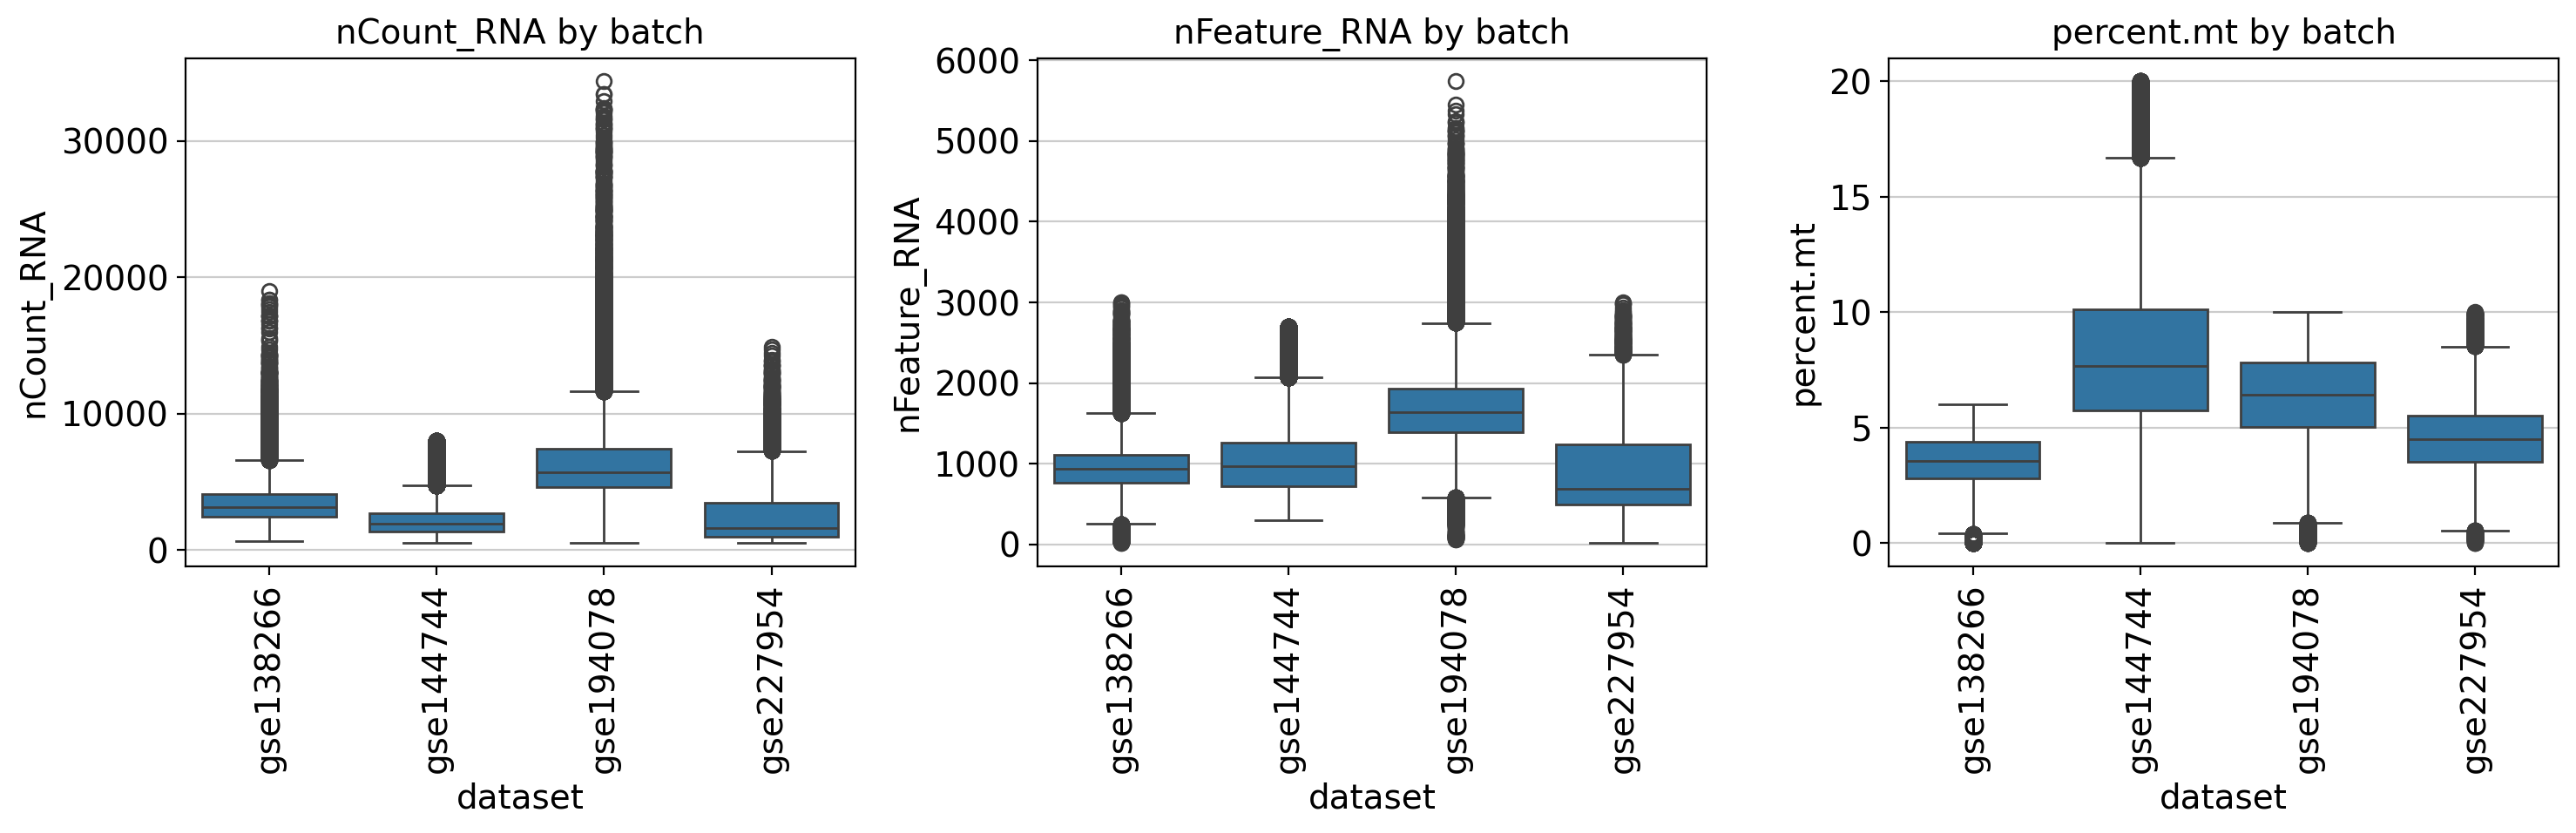


2. CHECKING BATCH MIXING IN DIMENSIONALITY REDUCTION SPACE


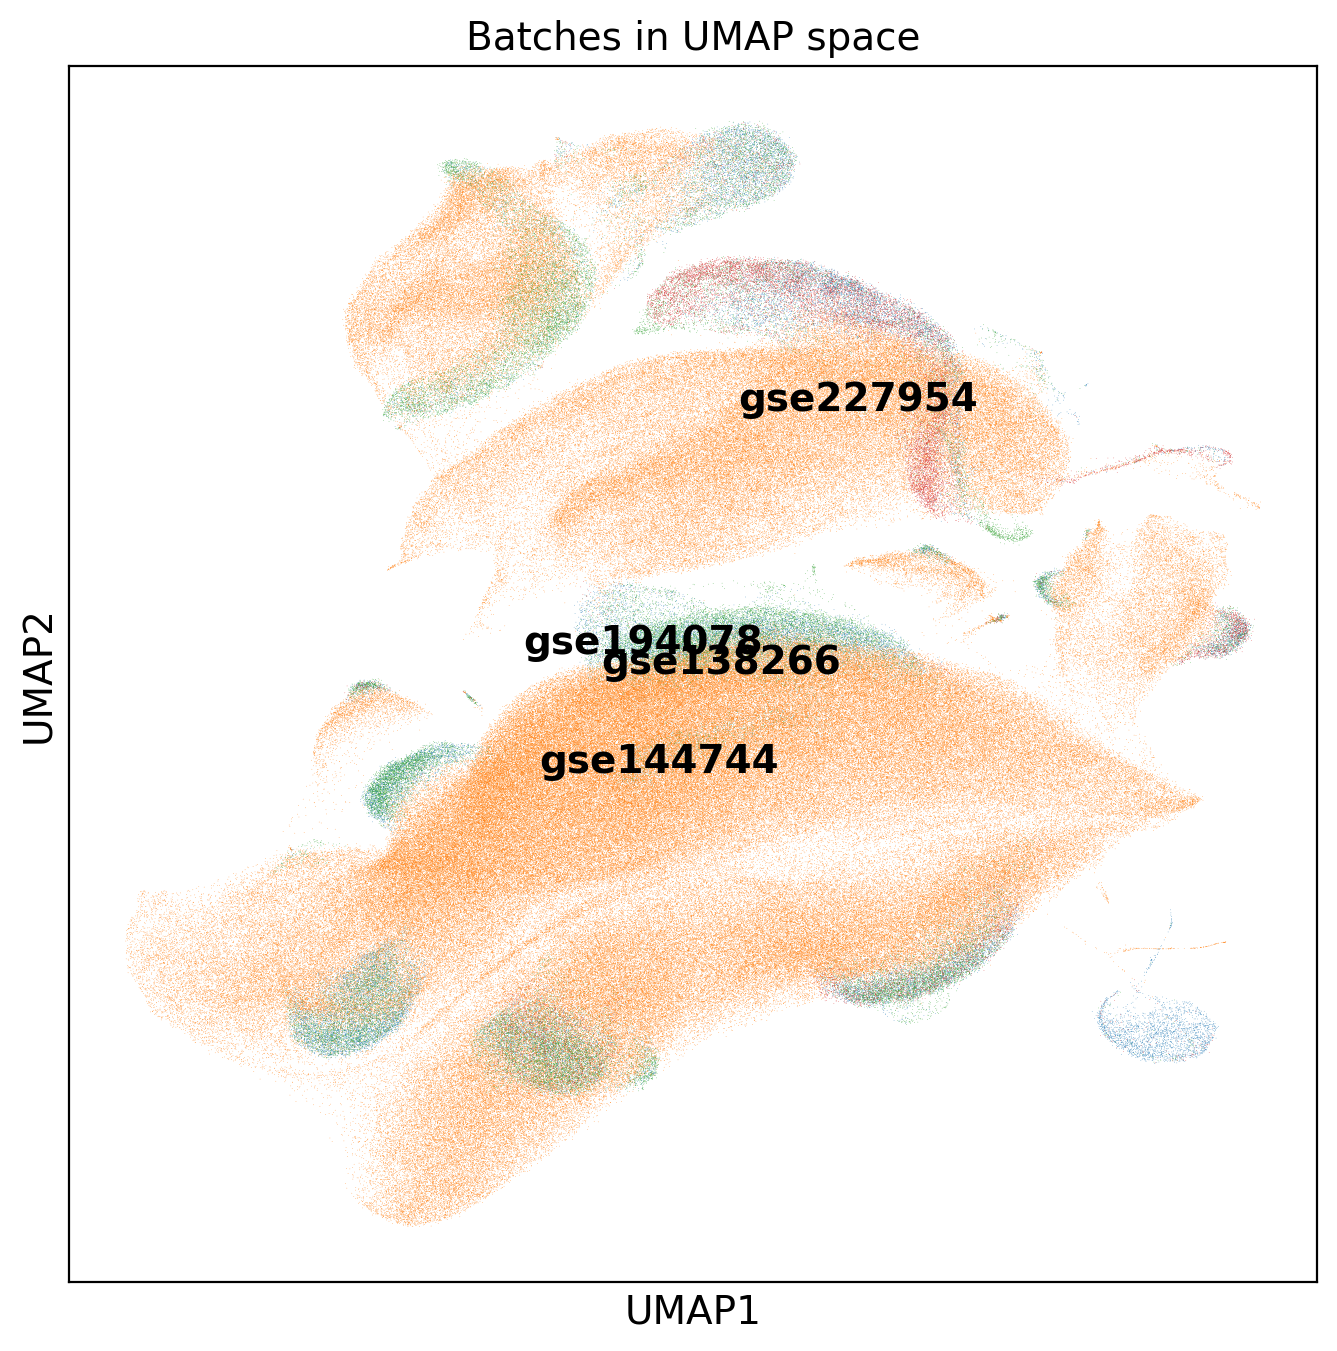


3. CHECKING CELL TYPE CONSISTENCY ACROSS BATCHES


<Figure size 1200x800 with 0 Axes>

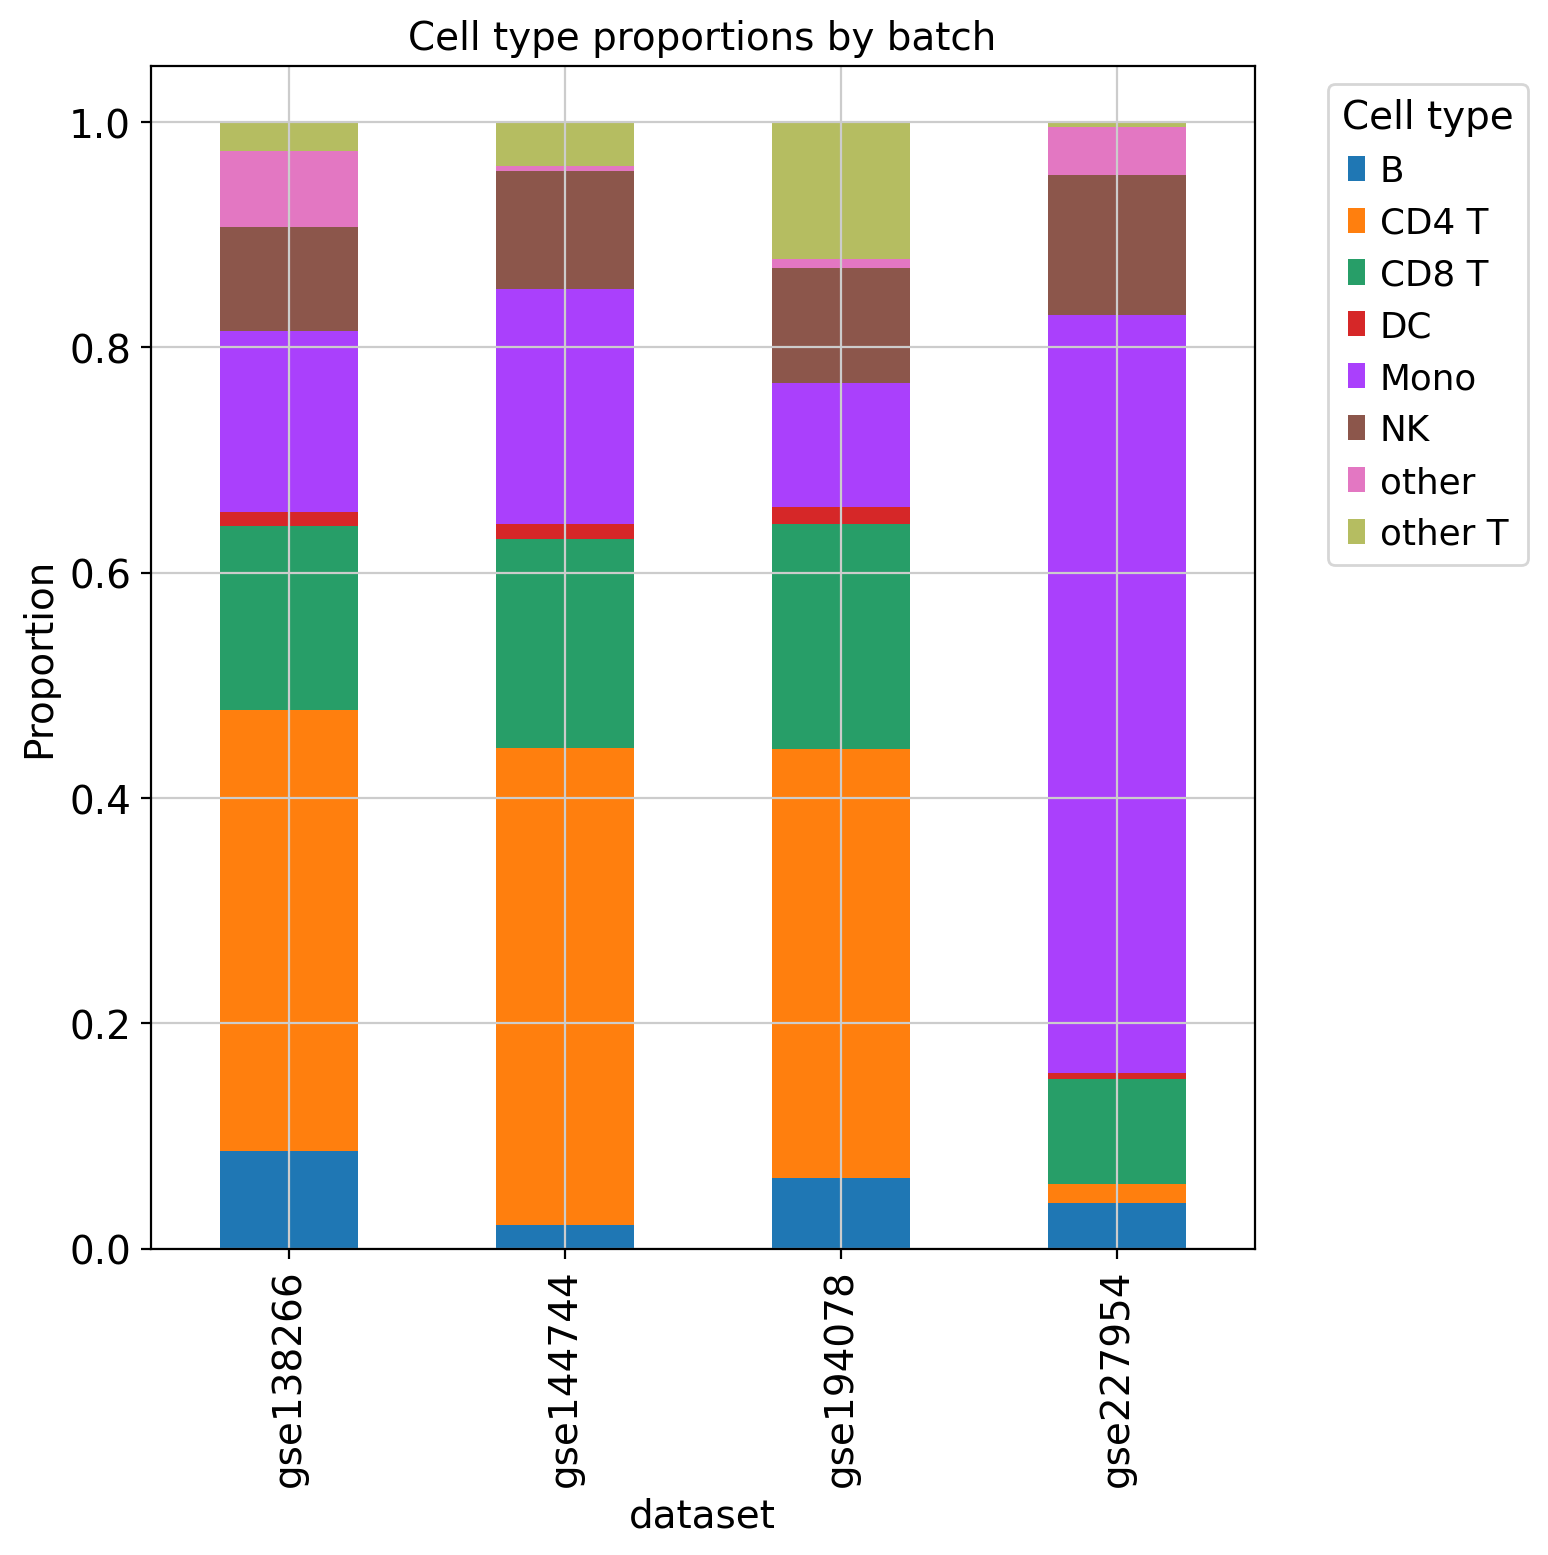


Kolmogorov-Smirnov test for cell type proportions between batches:
  gse138266 vs gse144744: KS statistic = 0.2500, p-value = 0.9801
  gse138266 vs gse194078: KS statistic = 0.2500, p-value = 0.9801
  gse138266 vs gse227954: KS statistic = 0.3750, p-value = 0.6601


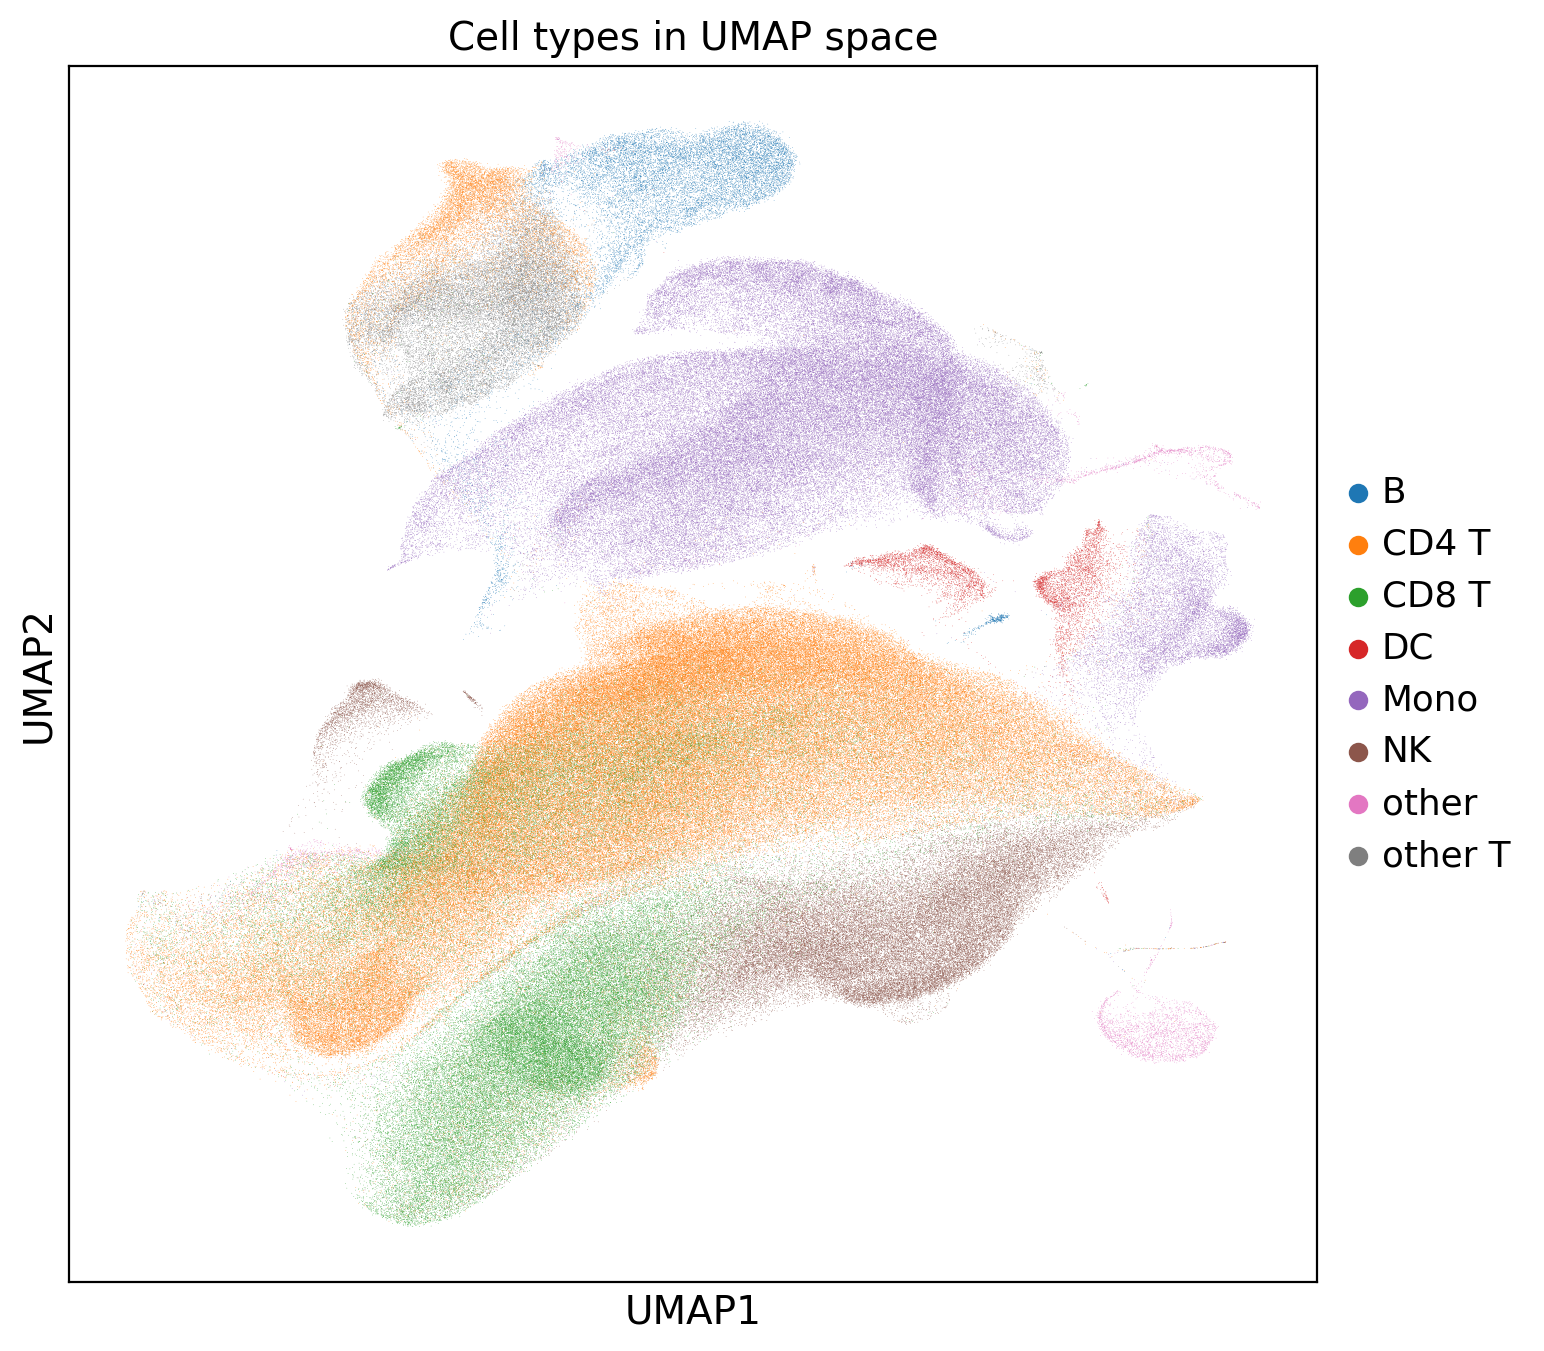


Checking batch mixing for cell type: other T (n=25166 cells)


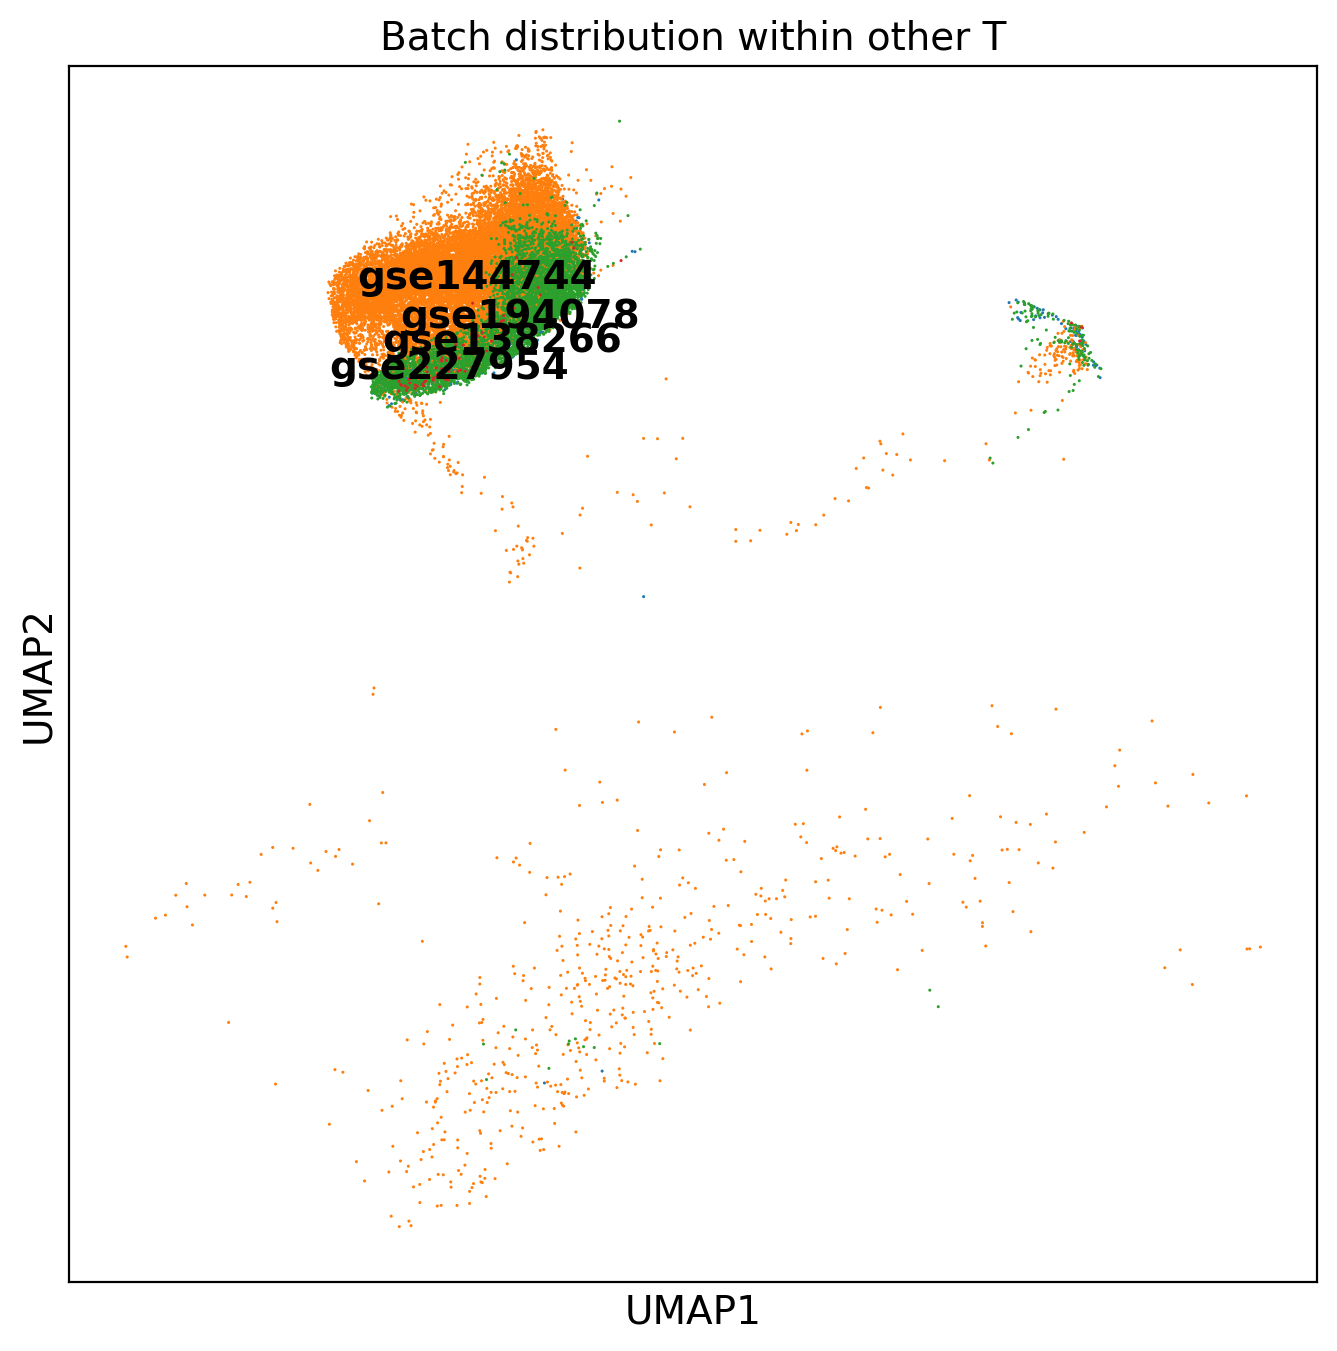


Checking batch mixing for cell type: CD4 T (n=239553 cells)


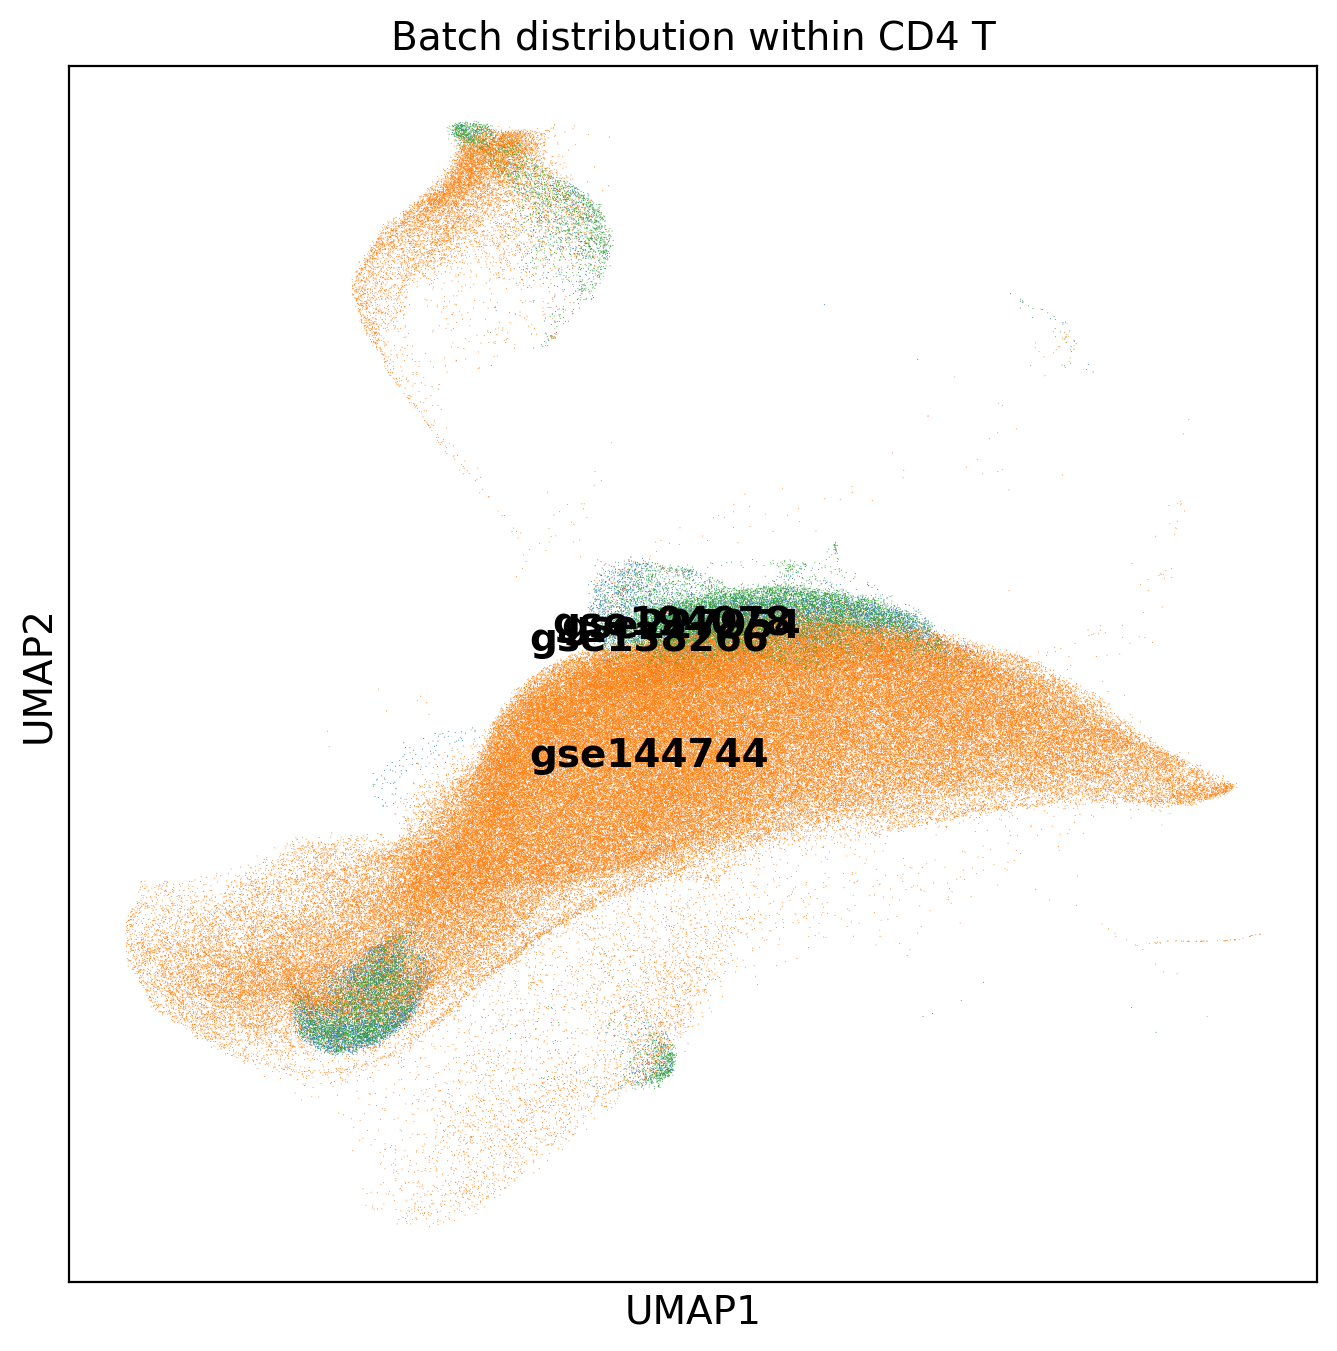


Checking batch mixing for cell type: NK (n=61761 cells)


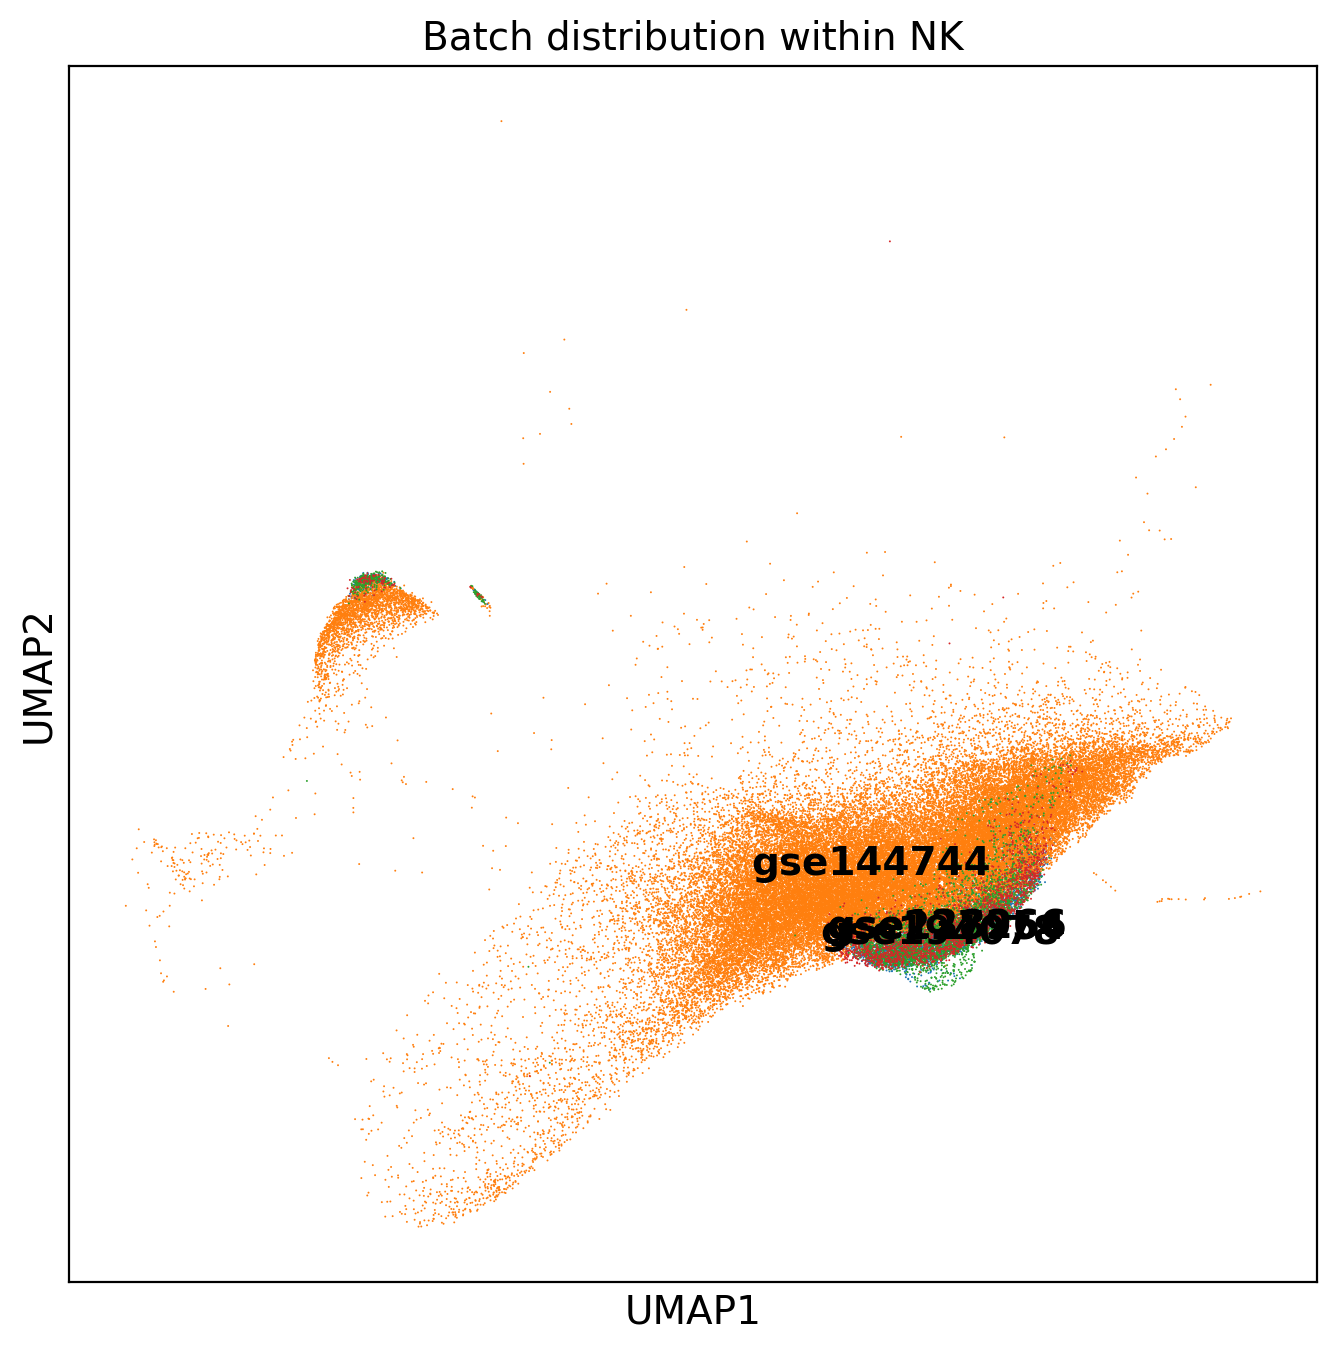


Checking batch mixing for cell type: DC (n=7877 cells)


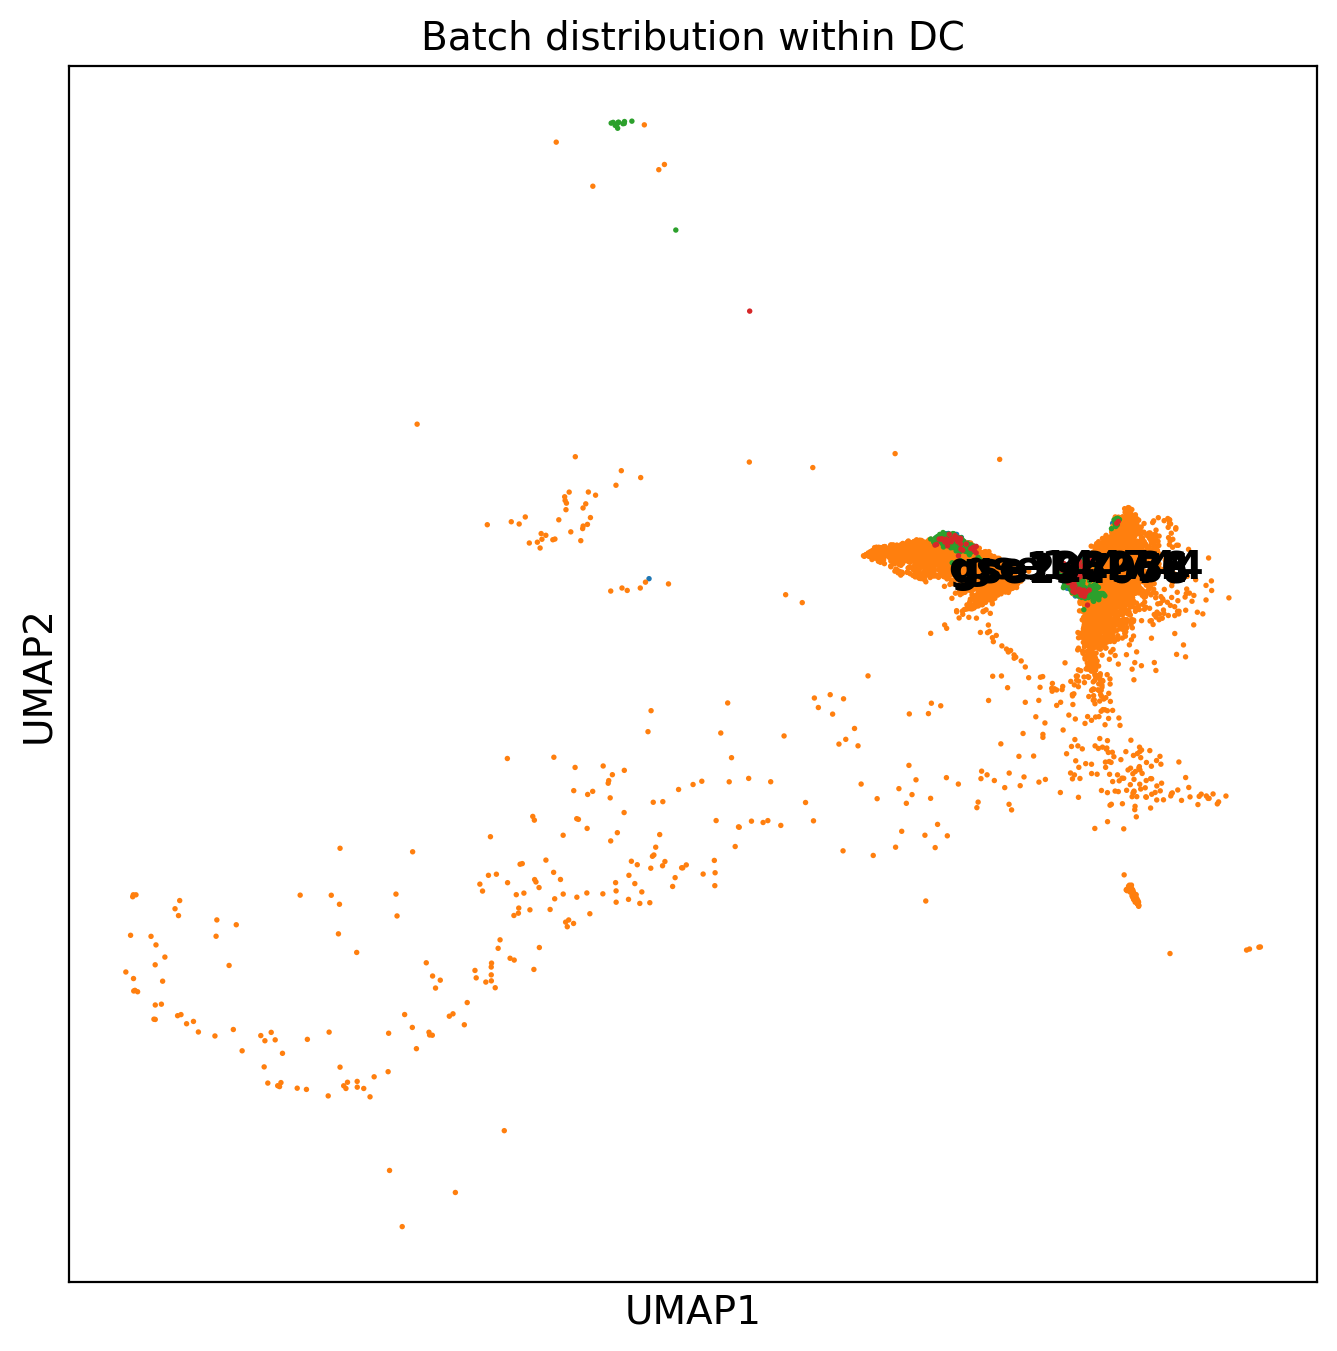


Checking batch mixing for cell type: CD8 T (n=107182 cells)


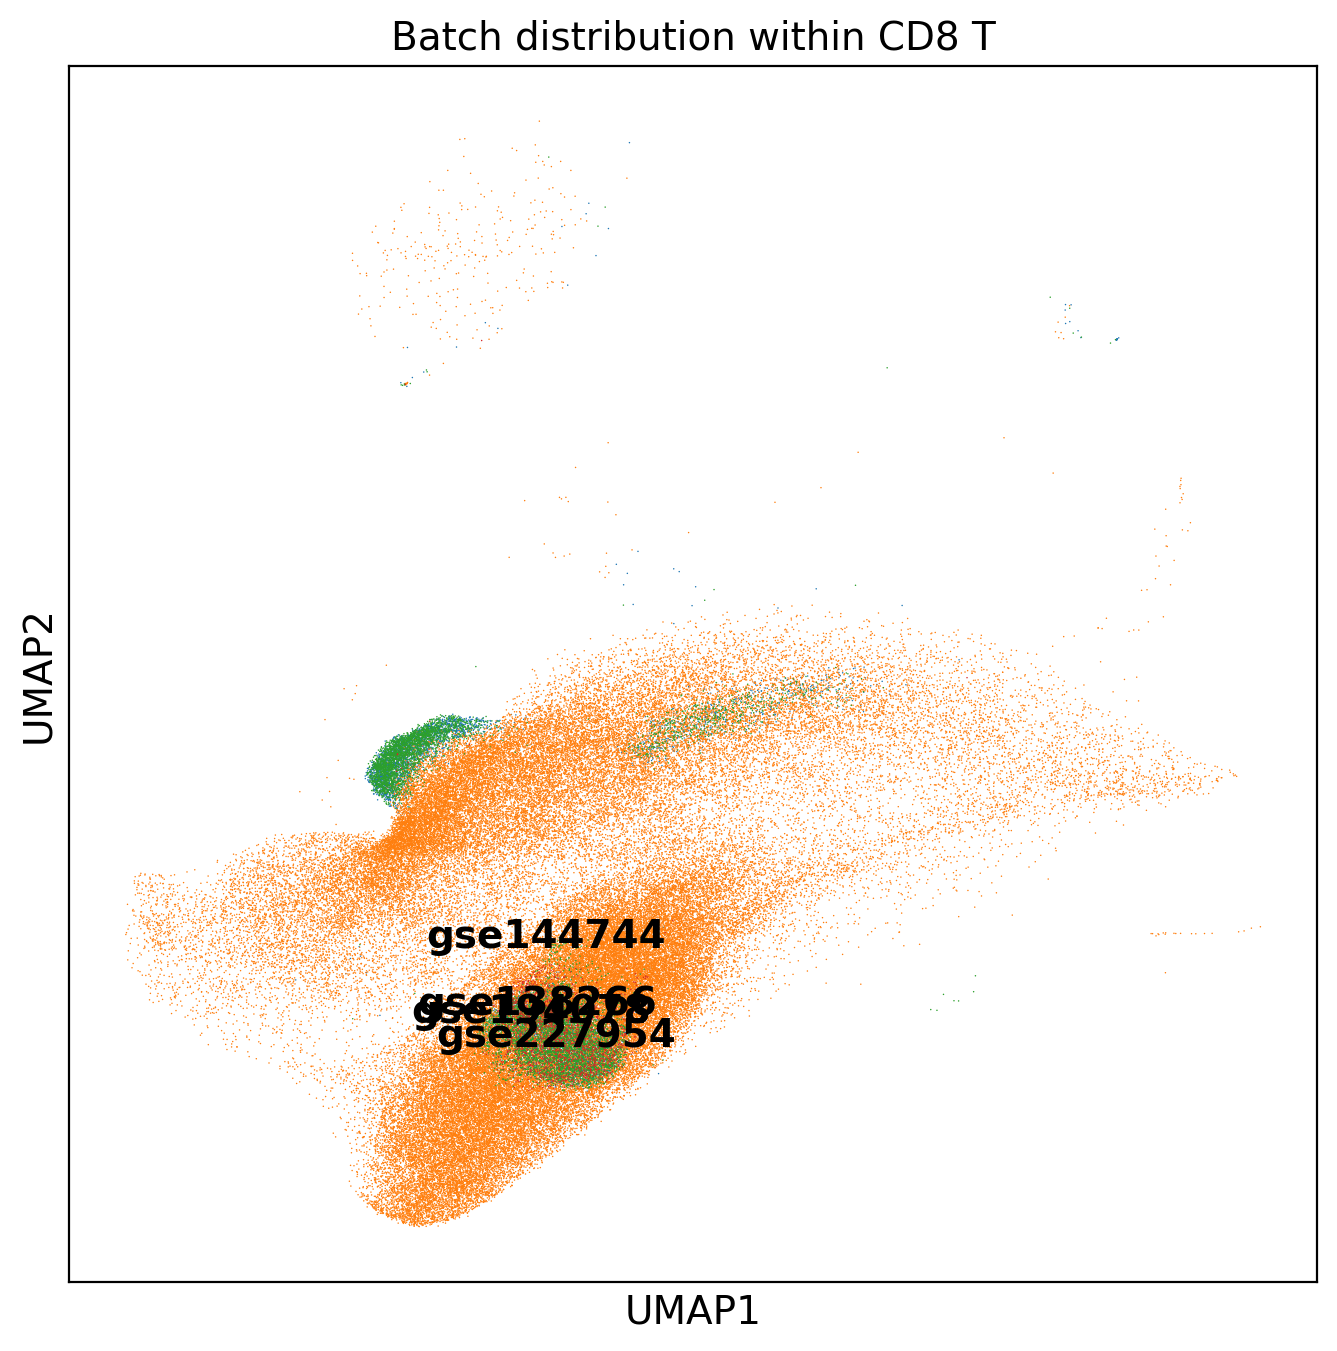


4. CHECKING LATENT SPACE STRUCTURE
Analyzing corrected latent space...


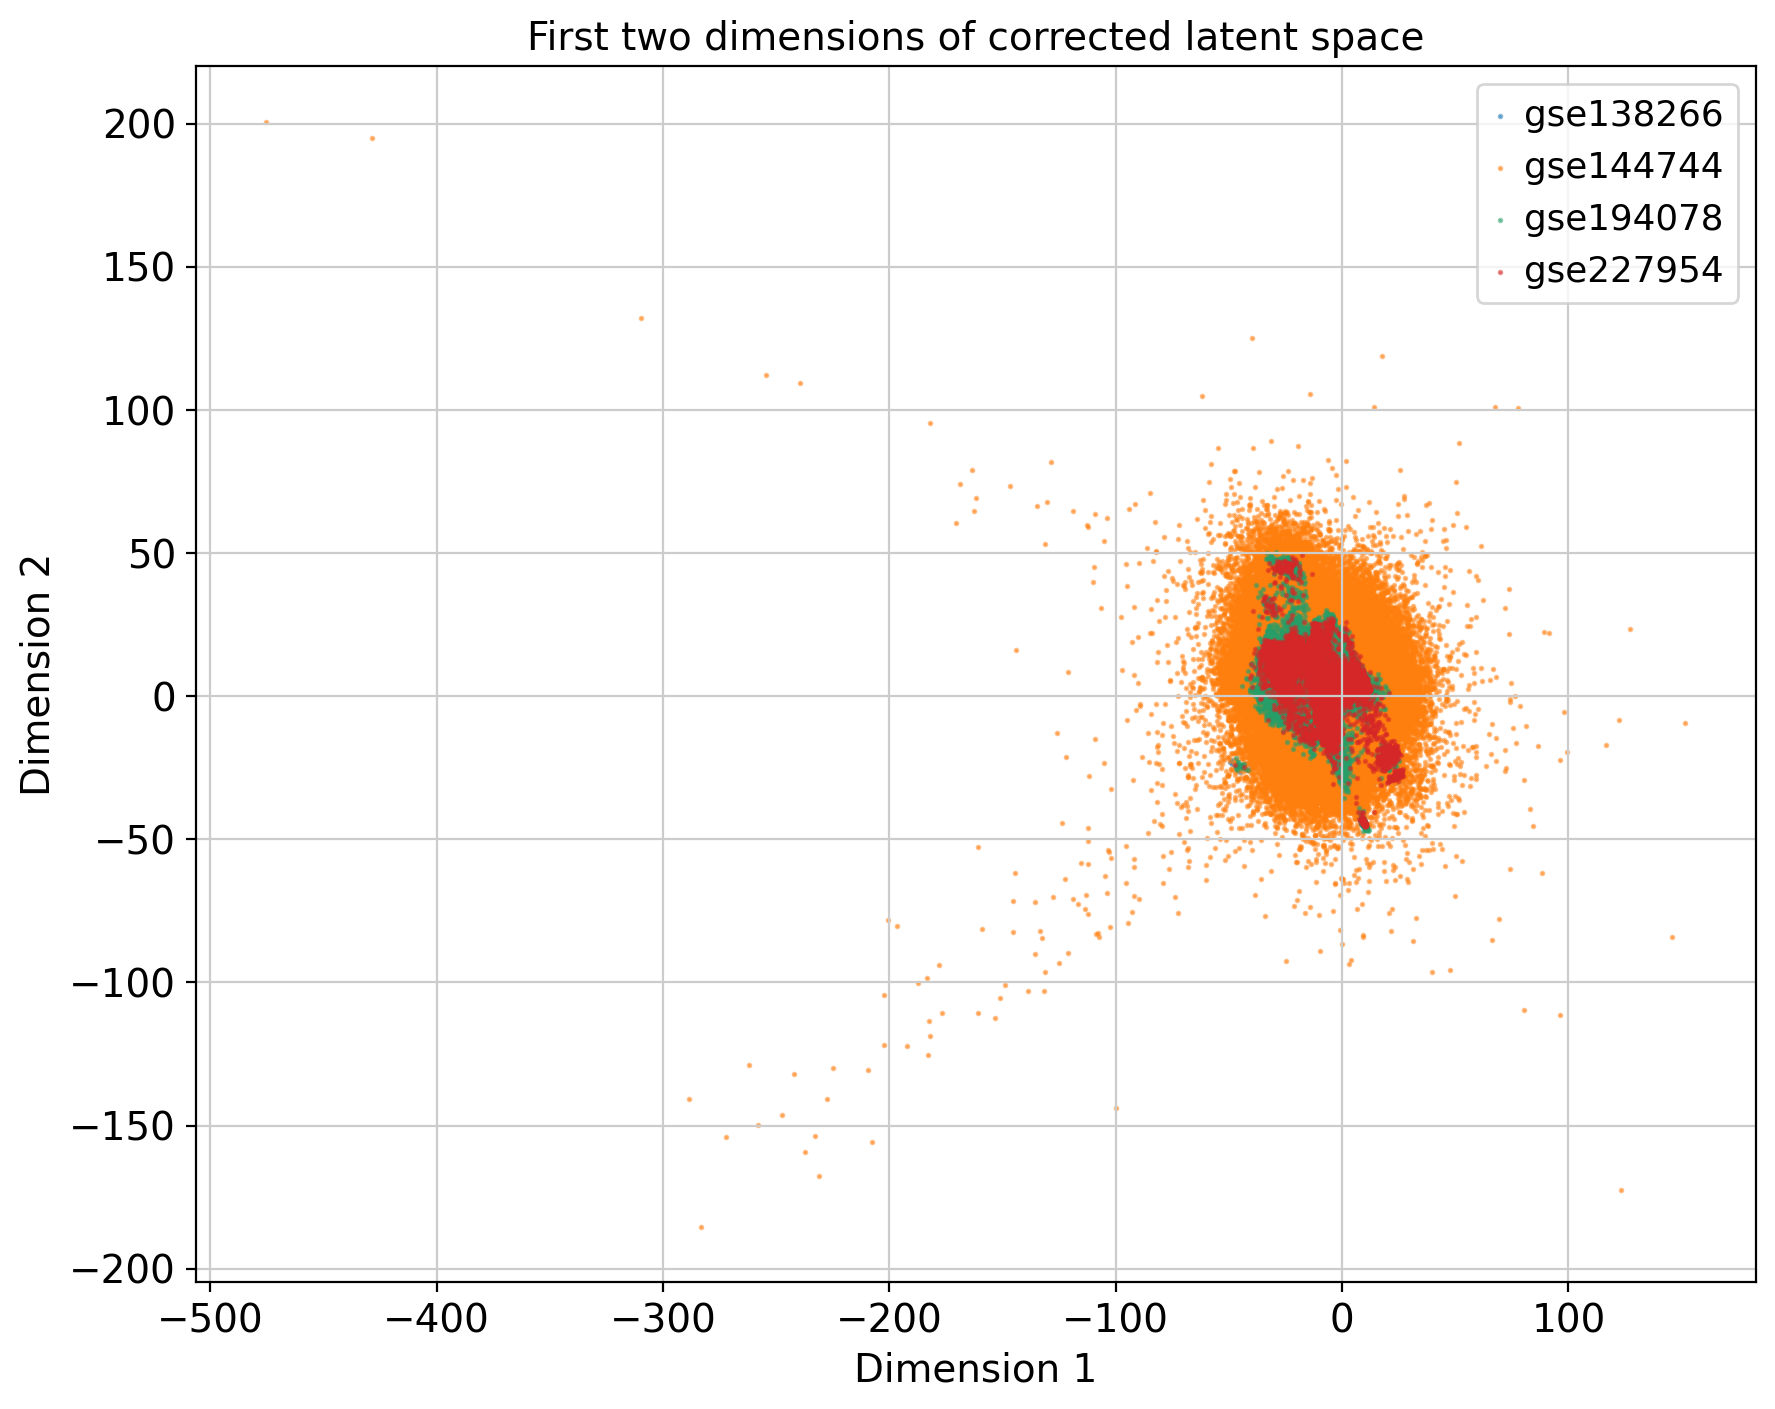


5. CHECKING GENE VARIANCE CONSISTENCY ACROSS BATCHES


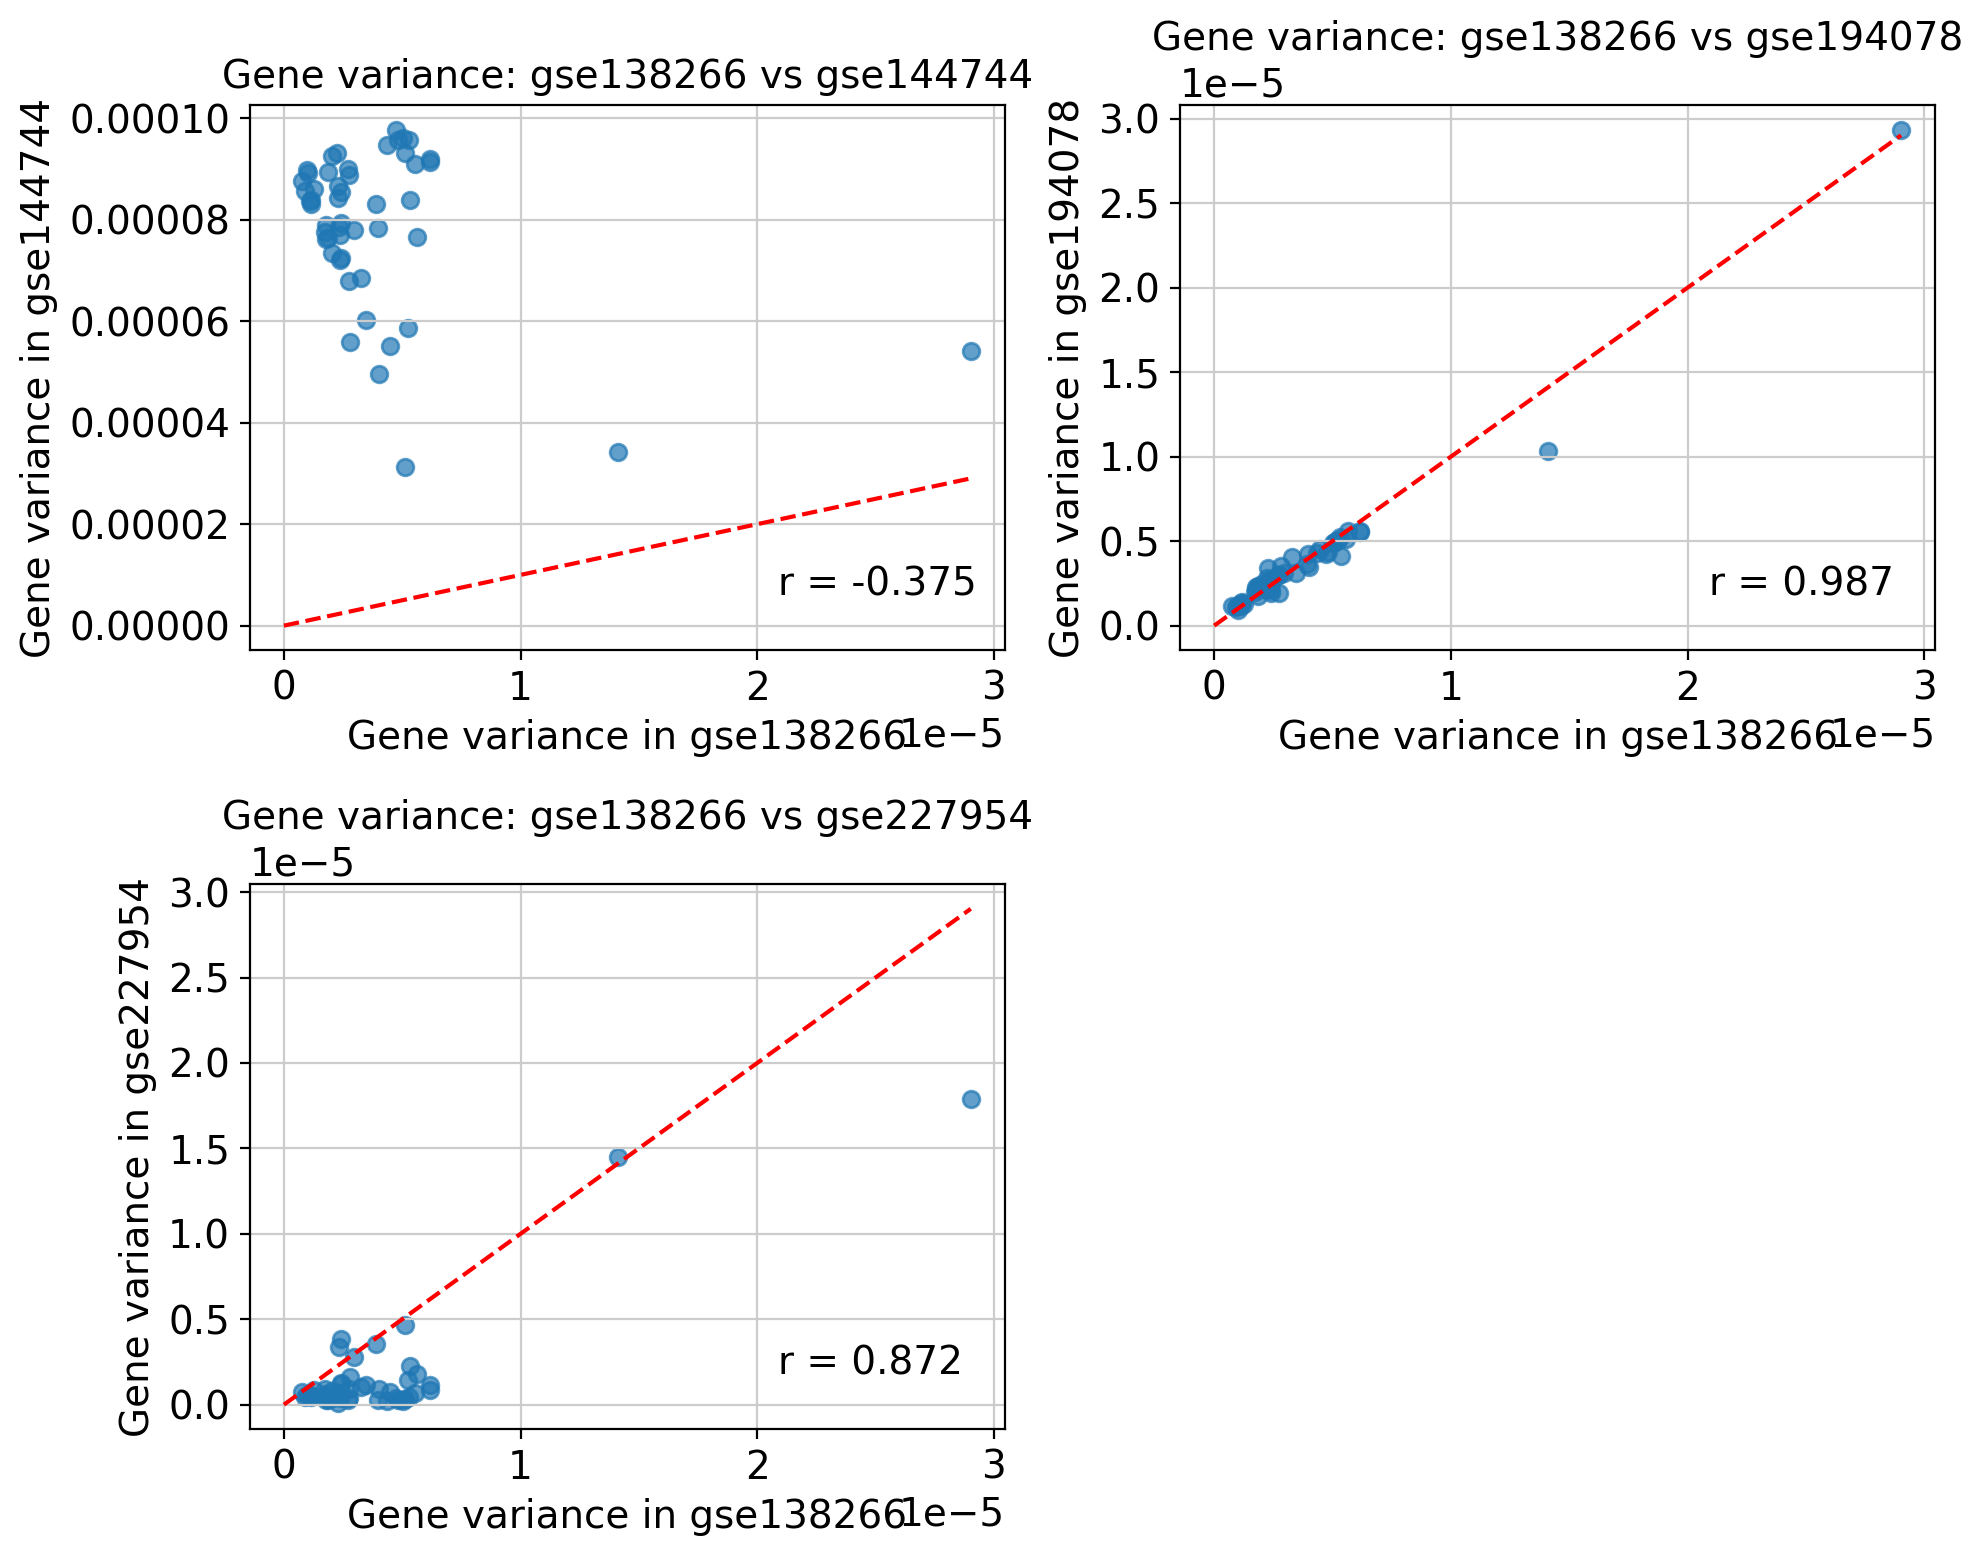


6. CHECKING LOCAL NEIGHBORHOOD PRESERVATION (KBET-LIKE ANALYSIS)
Analyzing local neighborhood batch balance...


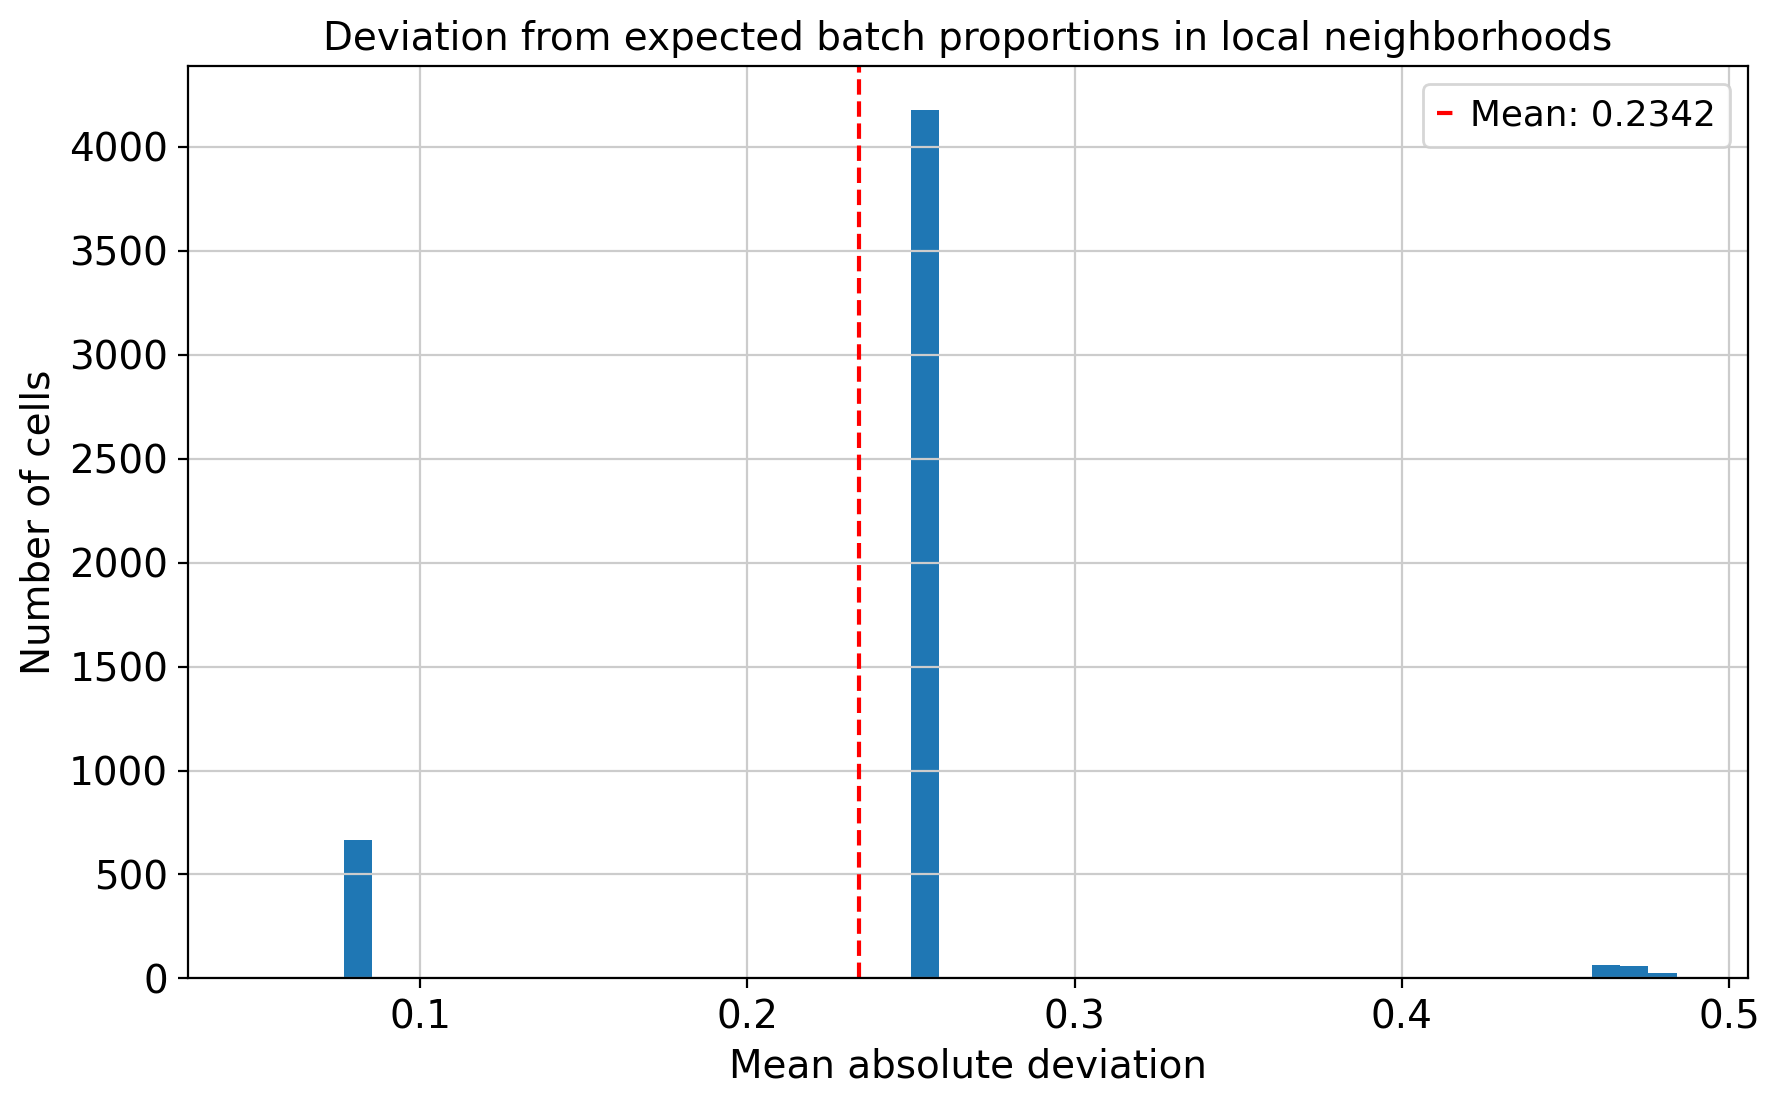

Mean neighborhood batch balance deviation: 0.2342
Ideal value is 0, typical good integration: <0.3

7. INTEGRATION QC SUMMARY
Total cells: 589218
Total genes: 14362
Number of batches: 4
Number of cell types: 8

Batch distribution:
  gse144744: 491888 cells (83.5%)
  gse138266: 40207 cells (6.8%)
  gse194078: 39883 cells (6.8%)
  gse227954: 17240 cells (2.9%)

FINAL VERDICT:
Please examine the plots and statistics above to determine if your integration was successful.
A good integration should show:
1. Similar QC metric distributions across batches
2. Good mixing of batches in UMAP and latent space
3. Consistent cell type proportions (unless biologically expected to differ)
4. Low neighborhood batch balance deviation (<0.3)
5. High correlation of gene variances between batches


In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Set matplotlib settings for better plots
sc.settings.set_figure_params(dpi=100, figsize=(8, 8))

def check_anndata_integration(adata, batch_key='dataset', celltype_key='predicted.celltype.l1'):
    """
    Perform quality checks on integrated AnnData object.
    
    Parameters:
    -----------
    adata : AnnData
        The integrated AnnData object
    batch_key : str
        Column in adata.obs containing batch/dataset information
    celltype_key : str
        Column in adata.obs containing cell type annotations
    """
    print(f"Running integration QC checks on AnnData with {adata.n_obs} cells and {adata.n_vars} genes")
    
    # 1. Basic QC metrics distribution by batch
    print("\n1. CHECKING BASIC QC METRICS DISTRIBUTION BY BATCH")
    qc_metrics = ['nCount_RNA', 'nFeature_RNA', 'percent.mt']
    
    fig, axes = plt.subplots(1, len(qc_metrics), figsize=(15, 5))
    for i, metric in enumerate(qc_metrics):
        if metric in adata.obs.columns:
            sns.boxplot(x=batch_key, y=metric, data=adata.obs, ax=axes[i])
            axes[i].set_title(f"{metric} by batch")
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.show()
    
    # 2. Check batch mixing in UMAP space
    print("\n2. CHECKING BATCH MIXING IN DIMENSIONALITY REDUCTION SPACE")
    sc.pl.umap(adata, color=batch_key, title=f"Batches in UMAP space", legend_loc='on data')
    
    # 3. Check cell type consistency across batches
    print("\n3. CHECKING CELL TYPE CONSISTENCY ACROSS BATCHES")
    if celltype_key in adata.obs.columns:
        # Calculate cell type proportions per batch
        celltype_props = pd.crosstab(
            adata.obs[batch_key], 
            adata.obs[celltype_key], 
            normalize='index'
        )
        
        # Plot cell type proportions
        plt.figure(figsize=(12, 8))
        celltype_props.plot(kind='bar', stacked=True)
        plt.title('Cell type proportions by batch')
        plt.ylabel('Proportion')
        plt.legend(title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        # Statistical test for cell type proportions
        datasets = adata.obs[batch_key].unique()
        print(f"\nKolmogorov-Smirnov test for cell type proportions between batches:")
        reference_batch = datasets[0]
        for batch in datasets[1:]:
            dist1 = celltype_props.loc[reference_batch]
            dist2 = celltype_props.loc[batch]
            ks_stat, p_val = ks_2samp(dist1, dist2)
            print(f"  {reference_batch} vs {batch}: KS statistic = {ks_stat:.4f}, p-value = {p_val:.4f}")
            
        # Check cell type UMAP overlap
        sc.pl.umap(adata, color=celltype_key, title=f"Cell types in UMAP space")
        
        # Check cell types separated by batch
        # Plot UMAP for each cell type, colored by batch
        celltypes = adata.obs[celltype_key].unique()
        sample_celltypes = np.random.choice(celltypes, min(5, len(celltypes)), replace=False)
        for ct in sample_celltypes:
            subset = adata[adata.obs[celltype_key] == ct].copy()
            print(f"\nChecking batch mixing for cell type: {ct} (n={subset.n_obs} cells)")
            sc.pl.umap(subset, color=batch_key, title=f"Batch distribution within {ct}", legend_loc='on data')
            
    # 4. Check latent space structure
    print("\n4. CHECKING LATENT SPACE STRUCTURE")
    # PCA on latent space
    if 'corrected_latent' in adata.obsm:
        print("Analyzing corrected latent space...")
        latent = pd.DataFrame(adata.obsm['corrected_latent'])
        latent['batch'] = adata.obs[batch_key].values
        
        # Plot first 2 dimensions of latent space
        plt.figure(figsize=(10, 8))
        batches = latent['batch'].unique()
        for batch in batches:
            subset = latent[latent['batch'] == batch]
            plt.scatter(subset[0], subset[1], label=batch, alpha=0.5, s=1)
        plt.title('First two dimensions of corrected latent space')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.legend()
        plt.show()
    
    # 5. Gene variance consistency check
    print("\n5. CHECKING GENE VARIANCE CONSISTENCY ACROSS BATCHES")
    # Select a small set of highly variable genes to check
    n_hvg = 50
    if 'highly_variable' in adata.var:
        hvg = adata.var.index[adata.var['highly_variable']].tolist()[:n_hvg]
    else:
        hvg = adata.var_names[:n_hvg]
    
    # Calculate gene variance per batch
    gene_var_by_batch = {}
    for batch in adata.obs[batch_key].unique():
        batch_data = adata[adata.obs[batch_key] == batch]
        gene_var = np.var(batch_data[:, hvg].X.toarray(), axis=0) if isinstance(batch_data.X, np.ndarray) else np.var(batch_data[:, hvg].X.toarray(), axis=0)
        gene_var_by_batch[batch] = gene_var
    
    # Convert to DataFrame for easy plotting
    gene_var_df = pd.DataFrame(gene_var_by_batch, index=hvg)
    
    # Plot variance correlation
    plt.figure(figsize=(10, 8))
    ref_batch = list(gene_var_by_batch.keys())[0]
    other_batches = list(gene_var_by_batch.keys())[1:min(4, len(gene_var_by_batch))]
    
    for i, batch in enumerate(other_batches):
        plt.subplot(2, 2, i+1)
        plt.scatter(gene_var_df[ref_batch], gene_var_df[batch], alpha=0.7)
        plt.plot([0, gene_var_df[ref_batch].max()], [0, gene_var_df[ref_batch].max()], 'r--')
        plt.xlabel(f'Gene variance in {ref_batch}')
        plt.ylabel(f'Gene variance in {batch}')
        plt.title(f'Gene variance: {ref_batch} vs {batch}')
        
        # Calculate correlation
        corr = np.corrcoef(gene_var_df[ref_batch], gene_var_df[batch])[0, 1]
        plt.annotate(f'r = {corr:.3f}', xy=(0.7, 0.1), xycoords='axes fraction')
    
    plt.tight_layout()
    plt.show()
    
    # 6. Check local neighborhood preservation
    print("\n6. CHECKING LOCAL NEIGHBORHOOD PRESERVATION (KBET-LIKE ANALYSIS)")
    if 'connectivities' in adata.obsp:
        print("Analyzing local neighborhood batch balance...")
        
        # Sample cells for efficiency
        max_cells = 5000
        idx = np.random.choice(adata.n_obs, size=min(max_cells, adata.n_obs), replace=False)
        adata_sample = adata[idx].copy()
        
        # Create neighbor graph if it doesn't exist
        if 'neighbors' not in adata_sample.uns:
            sc.pp.neighbors(adata_sample, use_rep='X_pca')
        
        # Calculate batch enrichment in neighborhoods
        batch_cat = pd.Categorical(adata_sample.obs[batch_key])
        n_batches = len(batch_cat.categories)
        
        # Convert categorical batch to one-hot encoding
        batch_oh = pd.get_dummies(batch_cat)
        
        # Get normalized connectivities
        connectivities = adata_sample.obsp['connectivities']
        
        # Normalize connectivities to sum to 1 for each cell
        row_sums = connectivities.sum(axis=1).A1
        connectivities_norm = connectivities.copy()
        connectivities_norm.data /= np.repeat(row_sums, np.diff(connectivities.indptr))
        
        # Expected batch distribution (global proportions)
        expected_batch_props = batch_oh.mean().values
        
        # Calculate observed batch proportions in each neighborhood
        observed_batch_props = connectivities_norm @ batch_oh.values
        
        # Calculate deviation from expected
        deviation = np.abs(observed_batch_props - expected_batch_props)
        mean_deviation = np.mean(deviation, axis=1)
        
        # Plot distribution of deviations
        plt.figure(figsize=(10, 6))
        plt.hist(mean_deviation, bins=50)
        plt.axvline(x=mean_deviation.mean(), color='r', linestyle='--', 
                    label=f'Mean: {mean_deviation.mean():.4f}')
        plt.title('Deviation from expected batch proportions in local neighborhoods')
        plt.xlabel('Mean absolute deviation')
        plt.ylabel('Number of cells')
        plt.legend()
        plt.show()
        
        print(f"Mean neighborhood batch balance deviation: {mean_deviation.mean():.4f}")
        print(f"Ideal value is 0, typical good integration: <0.3")
        
    # 7. Summary statistics
    print("\n7. INTEGRATION QC SUMMARY")
    print(f"Total cells: {adata.n_obs}")
    print(f"Total genes: {adata.n_vars}")
    print(f"Number of batches: {adata.obs[batch_key].nunique()}")
    if celltype_key in adata.obs.columns:
        print(f"Number of cell types: {adata.obs[celltype_key].nunique()}")
    
    # Batch distribution
    batch_counts = adata.obs[batch_key].value_counts()
    print("\nBatch distribution:")
    for batch, count in batch_counts.items():
        print(f"  {batch}: {count} cells ({count/adata.n_obs*100:.1f}%)")
    
    # Final verdict
    print("\nFINAL VERDICT:")
    print("Please examine the plots and statistics above to determine if your integration was successful.")
    print("A good integration should show:")
    print("1. Similar QC metric distributions across batches")
    print("2. Good mixing of batches in UMAP and latent space")
    print("3. Consistent cell type proportions (unless biologically expected to differ)")
    print("4. Low neighborhood batch balance deviation (<0.3)")
    print("5. High correlation of gene variances between batches")

# Run the integration QC check
# Load your integrated AnnData object
# anndata_integrated = sc.read_h5ad("post_integrazione_pbmc_1_umap_in_norm_most_var.h5ad")

# Modify these parameters based on your column names
check_anndata_integration(
    anndata_integrated, 
    batch_key='dataset',  # Column containing batch/dataset information
    celltype_key='predicted.celltype.l1'  # Column containing cell type annotations
)

